In [1]:
!pip install -q datasets
from datasets import load_dataset
emotions = load_dataset("emotion")

# Understanding the Dataset

In [2]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_set = emotions["train"]
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
emotions['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [7]:
#converting labels into integers
def label_converter(row):
  return emotions["train"].features["label"].int2str(row)

In [8]:
df["label_name"]=df["label"].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Data Visualization

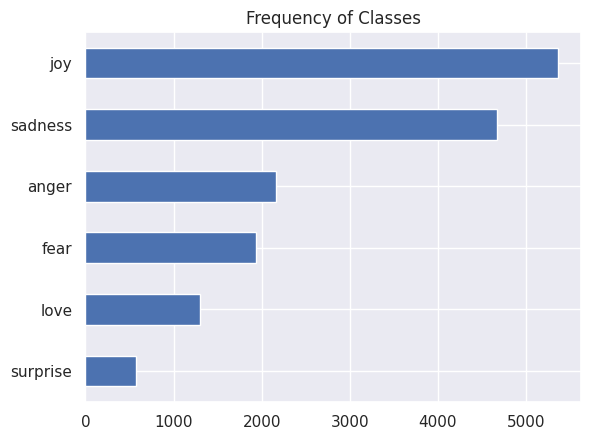

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [10]:
emotions.reset_format()#converting back to tensor

# TOKENIZATION

In [11]:
!pip install -q transformers

In [12]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)#loading the tokenizer for distilbert

def tokenize_function(batch):#function for tokenization
  return tokenizer(batch["text"], padding = True, truncation = True)

In [13]:
print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [14]:
tokenized_datasets = emotions.map(tokenize_function,
                                  batched = True,
                                  batch_size = None)#tokeinizing our dataset using the function defined above

In [15]:
print(tokenized_datasets["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# MODELING

In [16]:
from transformers import AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#checking if gpu is available or not and creating a variable to control gpu

model = (AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                            num_labels = 6).to(device))#loading the model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from sklearn.metrics import accuracy_score, f1_score
#defining performance metric
def compute_metrics(pred): #function for evaluating our models prediction
  labels = pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [18]:
!pip install accelerate -U
!pip install transformers[torch]

In [19]:
from transformers import TrainingArguments
#Defining training parameters
training_args = TrainingArguments(
    output_dir = "finetuning-emotion-model2",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm= False,
    push_to_hub=True
)

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:
from transformers import Trainer
#Building the model
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer
)

Cloning https://huggingface.co/Vinayak2104/finetuning-emotion-model2 into local empty directory.


In [22]:
trainer.train()# training the model(fine tunning)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.345255,0.898000,0.895024
2,0.570200,0.230885,0.919000,0.918998


TrainOutput(global_step=500, training_loss=0.5702159423828125, metrics={'train_runtime': 249.6082, 'train_samples_per_second': 128.201, 'train_steps_per_second': 2.003, 'total_flos': 720342861696000.0, 'train_loss': 0.5702159423828125, 'epoch': 2.0})

In [23]:
trainer.save_model('senti')#saving the model

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Aug16_14-38-36_edd3fc30e4b2/events.out.tfevents.1692196721.edd3fc30e4b2.16923.0:   0%|       …

To https://huggingface.co/Vinayak2104/finetuning-emotion-model2
   ffeabc4..bc38537  main -> main

   ffeabc4..bc38537  main -> main

To https://huggingface.co/Vinayak2104/finetuning-emotion-model2
   bc38537..3bd328d  main -> main

   bc38537..3bd328d  main -> main



In [24]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model="senti")#loading our model

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [25]:
pred = classifier(["I am very angry"])#using the model to predict
pred

[{'label': 'LABEL_3', 'score': 0.9436419606208801}]

In [26]:
def func(text):
  pred=classifier(text)[0]['label']
  if pred=='LABEL_0':
    return 'sadness'
  elif pred=='LABEL_1':
    return 'joy'
  elif pred=='LABEL_2':
    return 'love'
  elif pred=='LABEL_3':
    return 'anger'
  elif pred=='LABEL_4':
    return 'fear'
  elif pred=='LABEL_5':
    return 'surprise'


In [27]:
pip install gradio

In [28]:
import gradio as gr
descriptions = "This is an AI sentiment analyzer which checks and gets the emotions in a particular text. Just put in a sentence and you'll get the probable emotions behind that sentence"

app = gr.Interface(fn=func, inputs="text", outputs="text", title="Sentiment Analayser", description=descriptions)
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e621475f5007f6c8cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [33]:
trainer.save_model(r"/content/drive/MyDrive/LS project/trainedmodel")

In [30]:
notebook_login()

In [31]:
trainer.push_to_hub(commit_message='Training completed')